In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import tensorflow as tf

%cd '/content/drive/My Drive/GitHub Repositories/COVID-19'

dataDir = './datasets/dataset 01/Numpy Files'
train_x = np.load(dataDir+'/train_images.npy')
train_y = np.load(dataDir+'/train_labels.npy')
test_x = np.load(dataDir+'/test_images.npy')
test_y = np.load(dataDir+'/test_labels.npy')

print('Training Images: {} | Test Images: {}'.format(train_x.shape, test_x.shape))
print('Training Labels: {} | Test Labels: {}'.format(train_y.shape, test_y.shape))

# Data Normalization

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

train_x/=255.0
test_x/=255.0

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

/content/drive/My Drive/GitHub Repositories/COVID-19
Training Images: (5310, 224, 224, 3) | Test Images: (639, 224, 224, 3)
Training Labels: (5310,) | Test Labels: (639,)
Train: 0.0 , 255.0 | Test: 0.0 , 255.0
Train: 0.0 , 1.0 | Test: 0.0 , 1.0


In [3]:
from collections import Counter
# Class Mapping 
print('0:Normal | 1:Bacteria | 2:Viral | 3:COVID-19')

# Distribution of images in each class for Training-set
print(Counter(train_y))

# Distribution of images in each class for Test-set
print(Counter(test_y))

#Make Labels Categorical
train_y_oneHot = tf.one_hot(train_y, depth=4) 
test_y_oneHot = tf.one_hot(test_y, depth=4)

print('Training Labels: {} | Test Labels: {}'.format(train_y_oneHot.shape, test_y_oneHot.shape))

0:Normal | 1:Bacteria | 2:Viral | 3:COVID-19
Counter({1: 2540, 2: 1355, 0: 1349, 3: 66})
Counter({1: 246, 0: 234, 2: 149, 3: 10})
Training Labels: (5310, 4) | Test Labels: (639, 4)


In [5]:
baseModel = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
baseModel.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [17]:
# initialize the training data augmentation object
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15, fill_mode="nearest")

def InceptionV3_Model():
  # load the InceptionV3 network, ensuring the head FC layer sets are left off
  baseModel = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(output)
  output = tf.keras.layers.Flatten(name="flatten")(output)
  output = tf.keras.layers.Dense(1024, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(4, activation="softmax")(output)
  # place the head FC model on top of the base model (this will become the actual model we will train)
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

model = InceptionV3_Model()
print(model.summary())
# compile our model
# print("[INFO] compiling model...")
# initialize the initial learning rate, number of epochs to train for, and batch size
EPOCHS = 100
BATCHSIZE = 32
optimizer = tf.keras.optimizers.RMSprop()
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_752 (Conv2D)             (None, 111, 111, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_752 (BatchN (None, 111, 111, 32) 96          conv2d_752[0][0]                 
__________________________________________________________________________________________________
activation_752 (Activation)     (None, 111, 111, 32) 0           batch_normalization_752[0][0]    
____________________________________________________________________________________________

In [18]:
modelPath = './saved Models/Pretrained InceptionV3'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./saved Models/Pretrained InceptionV3/InceptionV3-best-model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

STEP_TRAIN = len(train_x) // BATCHSIZE
STEP_TEST = len(test_x) // BATCHSIZE
modelHistory = model.fit(trainAug.flow(train_x, train_y_oneHot, batch_size=BATCHSIZE), epochs=100, verbose=1, callbacks=[model_checkpoint],
                         validation_data=(test_x, test_y_oneHot), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST)

Model Directory Created
Epoch 1/100
165/165 [==============================] - ETA: 0s - loss: 1.3964 - acc: 0.5517
Epoch 00001: val_acc improved from -inf to 0.47261, saving model to ./saved Models/Pretrained InceptionV3/InceptionV3-best-model.h5
165/165 [==============================] - 57s 347ms/step - loss: 1.3964 - acc: 0.5517 - val_loss: 1.1929 - val_acc: 0.4726
Epoch 2/100
165/165 [==============================] - ETA: 0s - loss: 0.8316 - acc: 0.6466
Epoch 00002: val_acc did not improve from 0.47261
165/165 [==============================] - 54s 330ms/step - loss: 0.8316 - acc: 0.6466 - val_loss: 2.3619 - val_acc: 0.3928
Epoch 3/100
165/165 [==============================] - ETA: 0s - loss: 0.7640 - acc: 0.6834
Epoch 00003: val_acc did not improve from 0.47261
165/165 [==============================] - 54s 329ms/step - loss: 0.7640 - acc: 0.6834 - val_loss: 1.8308 - val_acc: 0.3803
Epoch 4/100
165/165 [==============================] - ETA: 0s - loss: 0.7425 - acc: 0.6792
Epoc

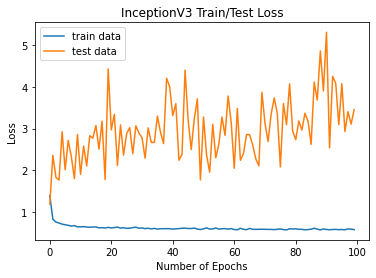

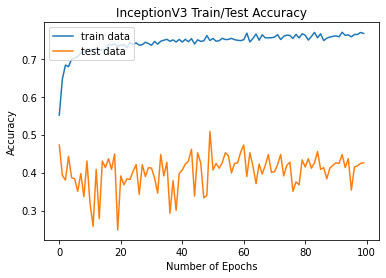

In [19]:
import matplotlib.pyplot as plt
losshistoryPath = './Train-Test History/Loss'
acchistoryPath = './Train-Test History/Accuracy'
if not os.path.exists(losshistoryPath) or not os.path.exists(acchistoryPath):
  os.makedirs(losshistoryPath)
  os.makedirs(acchistoryPath)
  
# Plot history: Loss
plt.plot(modelHistory.history['loss'], label='train data')
plt.plot(modelHistory.history['val_loss'], label='test data')
plt.title('InceptionV3 Train/Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('./Train-Test History/Loss/InceptionV3-loss-Graph.png', bbox_inches = "tight")
plt.show()

# Plot history: Accuracy
plt.plot(modelHistory.history['acc'], label='train data')
plt.plot(modelHistory.history['val_acc'], label='test data')
plt.title('InceptionV3 Train/Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('./Train-Test History/Accuracy/InceptionV3-Accuracy-Graph.png', bbox_inches = "tight")
plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('GroundTruths')
    plt.xlabel('Predictions \n Model Accuracy={:0.2f}% | Model Error={:0.2f}%'.format(accuracy*100, misclass*100))
    plt.savefig('./ReadMe Images/InceptionV3-cm.png', bbox_inches = "tight")
    plt.show()


predictions = model.predict(x=test_x, batch_size=32)
predictions = tf.keras.backend.argmax(predictions, axis=-1)

cm = confusion_matrix(test_y, predictions)
classes = ['Normal', 'Bacteria', 'Viral', 'COVID-19']
plot_confusion_matrix(cm=cm, normalize = False, target_names = classes, title= "Confusion Matrix (InceptionV3)")